In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#inspect table names for measurement for future use
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [11]:
#inspect column names for measurement for future use
columns = inspector.get_columns('measurement')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#inspect column names for station for future use
columns = inspector.get_columns('station')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [16]:
# Calculate the date one year from the last date in data set.

query_date =dt.date(2017, 8, 23) -dt.timedelta(days = 365)
print(query_date)

2016-08-23


            prcp
date            
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00
...          ...
2017-08-17  0.13
2017-08-19  0.09
2017-08-21  0.56
2017-08-22  0.50
2017-08-23  0.45

[2021 rows x 1 columns]


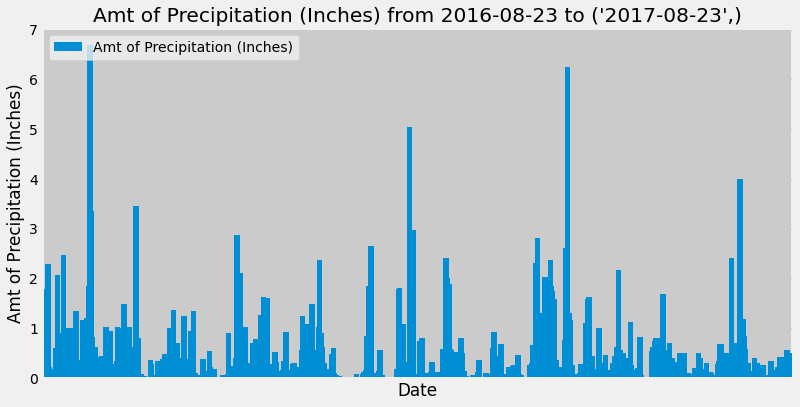

In [18]:
# Perform a query to retrieve the data and precipitation scores

yag_data=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >=query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

yag_df = pd.DataFrame(yag_data, columns = ['date', 'prcp'])

#Drop any null values

yag_df = yag_df.dropna(how="any")

#Set the index to the date column

yag_df = yag_df.set_index("date")
print(yag_df)

# Sort the dataframe by date

yag_df = yag_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data

#Create plot information

precip_plot = yag_df.plot(kind="bar", figsize = (12,6), width = 15)

#Create Legend

precip_plot.legend(["Amt of Precipitation (Inches)"], loc="upper left")

#Create axis labels
precip_plot.set_xlabel("Date")
precip_plot.set_ylabel("Amt of Precipitation (Inches)")

#Create the title
precip_plot.set_title (f"Amt of Precipitation (Inches) from {query_date} to {last_date}")
                       
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False  
) 

# Adjust graph for better display
plt.tight_layout
                
#Add grid lines
precip_plot.grid(zorder=1)
                      
#Create graph image
plt.savefig(f"./Images/Prec_data_from{query_date}_to_{last_date}.png", bbox_inches='tight')
                       
#Show the graph
plt.show()                       
                       



In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data

yag_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset

total_stations=session.query(Station.station).count()

print(f"The total number of Stations in the data is{total_stations}")
ttlstat_df=pd.DataFrame({"Total Stations": total_stations}, index = [0])
ttlstat_df


The total number of Stations in the data is9


,Total Stations
0,9


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).all()

for station, count in station_count:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count().desc()).\
        first()

(most_active_id, ) = most_active
print(f"The station id of the most active station is {most_active_id}.")

most_active_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_id) .\
        all()

for lowest_temp, highest_temp, avg_temp in most_active_data:
    print(f"The lowest temperature recorded at {most_active_id} was {lowest_temp}.")
    print(f"The highest temperature recorded at {most_active_id} was {highest_temp}.")
    print(f"The average temperature recorded at {most_active_id} was {avg_temp}.")
    
temp_df = pd.DataFrame({
    "Lowest Temperature": lowest_temp,
    "Highest Temperature": highest_temp,
    "Average Temperature": avg_temp
}, index=[0])

temp_df


The station id of the most active station is USC00519281.
The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.663781


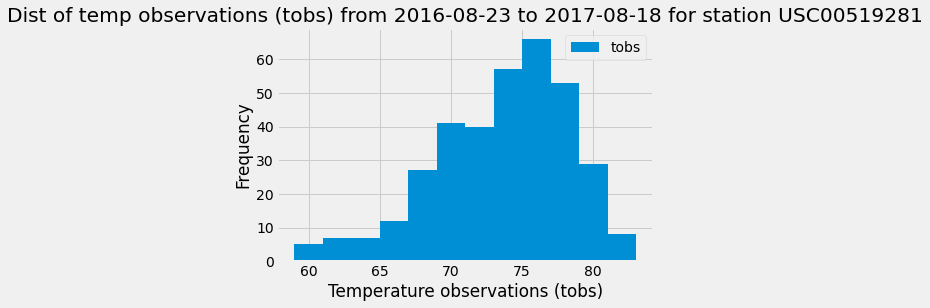

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prmeasure_tuple = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active_id).first()

(latest_date,) = prmeasure_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago =dt.date(2017, 8, 23) -dt.timedelta(days = 365)

last_year_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_id).\
    filter(Measurement.date >= date_year_ago).all()
    
last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])

last_year_data_df

plt.hist(last_year_data_df["tobs"], bins=12, label="tobs")
plt.ylabel('Frequency')
plt.xlabel('Temperature observations (tobs)')
plt.title(f"Dist of temp observations (tobs) from {date_year_ago} to {latest_date} for station {most_active_id}")
plt.grid(zorder=0)
plt.legend(loc="upper right")
plt.savefig(f"./Images/tobs_histogram_for_station_{most_active_id}.png", bbox_inches='tight')
plt.show()

# Close session

In [36]:
# Close Session
session.close()